# Modelling Consequences of Unemployment: Random and Fixed Effects
### by Min Zou
*(Work in progress. Please do not quote without authors' consent.)*

## Define 'unemployment scarring' effect
- There are two definitions:
 - Within unemployment: Clark et al. (2008)
 - Post unemployment: Clark et al. (2001), Lucas et al. (2003)
- Unemployment scarring effects on income have also been studied (ref).

## Preparing data
- DV: Life satisfaction 0-10
- IDV: Lead dummies (unemployment at t-1, t-2, t-3), lag dummies (within unemployment at t1,..., t5; post unemployment t1,..., t5)
- Control: Age, gender (random effect only), education, marital status, number of children, health, household income

## Modelling
- Previous research: 
 - Cross-sectional: ?
 - Panel: Random effect, mixed (essentially random effect) models with the exception of Clark et al. (2001) with potential room for improvement
- Problem of random effect models: Unobserved heterogeneity
- This study: compaing random effect and fixed effect

# Data preparation

In [ ]:
library(foreign);library(plm);library(plyr);library(dplyr);library(bife)

In [ ]:
file.to.merge <- 'respda' 
var <- c('paygl','jbsemp','jbsoc','jbot','jbsat2','jbsat4','jbsat6','jbsat7','jbsat','jbstat', 
         'age','sex','race','qfedhi','qfachi','qfvoc','scend', 
         'mastat','nchild','paygu','fihhmn',
         'jbhrs','jbft','jbsize','region2','jbsect','jbsic','hlstat','hlprb', 
         'ptrt5a1','ptrt5a2','ptrt5a3', 
         'lfsato','hlghq1','hlghq2', #life satisfaction, ghq-36, ghq-12 
         'lrwght') 
file.saved <- list.files('xxx//xxxx//xxxx//xxxx')
file.sel <- file.saved[which(grepl(file.to.merge,file.saved)==T)]
data.list <- lapply(file.sel, function(x){
    read.dta(x,convert.factors=F)[,c(match('id',names(read.dta(x))),
                                     na.omit(match(var,substring(names(read.dta(x)),2))))]})
data.list2 <- lapply(data.list,function(x){x$xwave <- substr(names(x)[2],1,1);x})

data.list3 <- lapply(data.list2,function(x){names(x) <- substring(names(x),2);x})
data <- do.call(rbind.fill,data.list3)
data$t.num <- as.numeric(as.factor(data$wave))
write.csv(data,'data.csv',row.names=F)

In [43]:
######## overal data prep ################################################################

data<-read.csv('data.csv')
data<-data[data$age>=16 & data$age<=60,]

## recoding

## create unemp & emp
data <- data[order(data$id,data$wave.num),]
data$unemp <- ifelse(data$jbstat==3,1,0) # unemployment
data$emp <- ifelse(data$jbstat==2,1,0) # in paid emp


## create jobsoc.3dgt, jobsoc2.dgt, jobsoc.1dgt
data$jbsoc.3dgt <- data$jbsoc
data$jbsoc.3dgt[data$jbsoc.3dgt == -9 | data$jbsoc.3dgt == -1 | (data$jbstat == 2 & data$jbsoc.3dgt == -8)] <- NA 
data$jbsoc.3dgt <- ifelse(data$emp == 1 & is.na(data$jbsoc.3dgt) == T &
			lag(data$emp,1) == 1 & lag(data$jbsoc.3dgt,1) > 0, lag(data$jbsoc.3dgt,1),data$jbsoc.3dgt)
data$jbsoc.2dgt <- floor(data$jbsoc.3dgt/10)
data$jbsoc.2dgt [data$jbsoc.2dgt==-1] <- -8
data$jbsoc.1dgt <- floor(data$jbsoc.3dgt/100)
data$jbsoc.1dgt [data$jbsoc.1dgt==-1] <- -8

data$jbsoc.3dgt.emp <- ifelse(data$emp==1,data$jbsoc.3dgt,NA)
data$jbsoc.2dgt.emp <- ifelse(data$emp==1,data$jbsoc.2dgt,NA)
data$jbsoc.1dgt.emp <- ifelse(data$emp==1,data$jbsoc.1dgt,NA)


## age
data$age [data$age == -9] <- NA

## sex
data$sex [data$sex < 0] <- NA #1-M 2-F

## year of schooling
data$scend [data$scend == -8 |data$scend == -9] <- NA
data$yrschl <- data$scend - 5

## experience
data$exp <- data$age - data$scend

## educational qualifications
data$edu <- data$qfedhi
data$edu [data$edu < 0] <- NA

#Higher Degree	1	122	1.2	1.2
#First Degree	2	598	5.8	6.0
#Teaching QF	3	225	2.2	2.3
#Other Higher QF	4	1207	11.8	12.2
#Nursing QF	5	215	2.1	2.2
#GCE A Levels	6	985	9.6	10.0
#GCE O Levels or Equi	7	2086	20.3	21.1

## academic qualifications
data$academic <- data$qfachi
data$academic [data$academic < 0] <- NA

#Higher Degree	1	122	1.2	1.2
#1st Degree	2	598	5.8	6.0
#HND,HNC,Teaching	3	496	4.8	5.0

## health
data$hlstat [data$hlstat == -9 |data$hlstat == -2] <- NA
data$health <- 6 - data$hlstat 

## marital status
data$mastat [data$mastat < 0] <- NA 
data$couple <- ifelse(	data$mastat == 1 | data$mastat == 2 | data$mastat == 7 | data$mastat == 98,
				1,0)  

## hhincome
data$hhincome <- data$fihhmn
data$hhincome [data$fihhmn < 0] <- NA

## jbhrs
data$wkhrs <- ifelse(data$jbhrs > 0, data$jbhrs, NA)

## full time job
data$fulltime <- data$jbft
data$fulltime [data$fulltime < 0] <- NA
data$fulltime <- ifelse(data$fulltime==1,1,0)

## emp status
data$empstat <- as.factor(ifelse(data$jbft==-8,3,ifelse(data$jbft<0,NA,data$jbft)))
levels(data$empstat) <- c('full time','part time','inactive')

## sector
data$private <- ifelse(data$jbsect==1,1,ifelse(data$jbsect>=2 & data$jbsect<=6,0,NA))

## life satisfaction
data$lfsato [data$lfsato < 0] <- NA

## region2
data$region2 [data$region2 < 0] <- NA

## nchild no need to recode


In [44]:
###################### prepare data for creating within unemp lag dummies #############################
data$unemp.1styr.each.slot <- ifelse(data$id == lag(data$id,1) & 
						 data$wave.num == lag(data$wave.num,1) + 1 &
						 data$unemp == 1 & lag(data$unemp,1) == 0 ,
						 1,0)

data<-data[order(data$id,-data$wave.num),]
data$wave.seq.check <- ave(data$wave.num,data$id,FUN=seq_along)
data$unemp.grp <- data$wave.num + data$wave.seq.check
data<-data[order(data$id,data$wave.num),]

data$unemp.withinid.each.slot <- ave(data$unemp.1styr.each.slot, data$id, data$unemp, data$unemp.grp,FUN = cumsum)
data$unemp.withinid.each.slot.bin <- ifelse(data$unemp.withinid.each.slot>0,1,0)
data$unemp.withinid.each.slot.seq <- ave(data$unemp.withinid.each.slot.bin, data$id, data$unemp.grp, data$unemp.withinid.each.slot,FUN = cumsum)

In [ ]:
###################### prepare data for creating emp after unemp lag dummies #############################
data$unemp.lastyr.each.slot <- ifelse(data$unemp == 1 & lead(data$unemp,1) == 0 &
						  data$wave.num == lead(data$wave.num) - 1 & 
						  data$id == lead(data$id,1) ,
						  1, 0)

sum(data$unemp.lastyr.each.slot)

In [33]:
################# create emp after unemployment lag dummies ##########################
lg <- 50

row.unemp.lastyr.each.slot <- which(data$unemp.lastyr.each.slot==1)
row.loop <- row.unemp.lastyr.each.slot
for (i in 1:lg) {
	rows <- row.loop[which(	data[row.loop+1,'emp'] == 1 & 
					data[row.loop+1,'id'] == data[row.loop,'id'] & 
					data[row.loop+1,'wave.num'] == data[row.loop,'wave.num']+1)]
	data[paste0('emp.postunemp.in1yr.t',i)] <- 0
	data[c(rows+1),paste0('emp.postunemp.in1yr.t',i)] <- 1
	row.loop <- rows+1
	#print(rows[1:5])
}

row.unemp.lastyr.each.slot <- which(data$unemp.lastyr.each.slot==1)
row.loop <- row.unemp.lastyr.each.slot
for (i in 1:lg) {
	if (i == 1) {rows <- row.loop[which(	data[row.loop+1,'emp'] == 0 & 
					data[row.loop+1,'id'] == data[row.loop,'id'] & 
					data[row.loop+1,'wave.num'] == data[row.loop,'wave.num']+1 &
					data[row.loop+2,'emp'] == 1 & 
					data[row.loop+2,'id'] == data[row.loop,'id'] & 
					data[row.loop+2,'wave.num'] == data[row.loop,'wave.num']+2) ]
	data[paste0('emp.postunemp.in2yr.t',i)] <- 0
	data[c(rows+2),paste0('emp.postunemp.in2yr.t',i)] <- 1
	row.loop <- rows+2}
	if (i >= 2) {rows <- row.loop[which(	data[row.loop+1,'emp'] == 1 & 
					data[row.loop+1,'id'] == data[row.loop,'id'] & 
					data[row.loop+1,'wave.num'] == data[row.loop,'wave.num']+1)]
	data[paste0('emp.postunemp.in2yr.t',i)] <- 0
	data[c(rows+1),paste0('emp.postunemp.in2yr.t',i)] <- 1
	row.loop <- rows+1}
	#print(rows[1:5])
}


for (i in 1:5) {
	data[,paste0('emp.postunemp.in1_2yr.t',i)] <- data[,paste0('emp.postunemp.in1yr.t',i)] + data[,paste0('emp.postunemp.in2yr.t',i)]
	}


################# create not in emp after unemployment lag dummies ##########################
lg <- 50

row.unemp.lastyr.each.slot <- which(data$unemp.lastyr.each.slot==1)
row.loop <- row.unemp.lastyr.each.slot
for (i in 1:lg) {
	rows <- row.loop[which(	data[row.loop+1,'emp'] == 0 & data[row.loop+1,'unemp'] == 0 & 
					data[row.loop+1,'id'] == data[row.loop,'id'] & 
					data[row.loop+1,'wave.num'] == data[row.loop,'wave.num']+1)]
	data[paste0('nonemp.postunemp.in1yr.t',i)] <- 0
	data[c(rows+1),paste0('nonemp.postunemp.in1yr.t',i)] <- 1
	row.loop <- rows+1
	#print(rows[1:5])
}

################ create jbsoc.3dgt at emp.postunemp ##################
## create jbsoc.3dgt.emp.at.unemp.t_1 ##
row.postunemp.t0 <- which(data$unemp.lastyr.each.slot==1)
len.unemp.withinid.each.slot <- data[row.postunemp.t0,'unemp.withinid.each.slot.seq']
row.jbsoc.3dgt.emp.at.unemp.t_1 <- row.postunemp.t0 - len.unemp.withinid.each.slot
data[row.postunemp.t0+1,'jbsoc.3dgt.emp.at.unemp.t_1']<-data[row.jbsoc.3dgt.emp.at.unemp.t_1,'jbsoc.3dgt.emp']

data$jbsoc.3dgt.emp.at.unemp.t_1 [lag(data$unemp.withinid.each.slot.seq,1) == 0] <- NA

data$jbsoc.2dgt.emp.at.unemp.t_1 <- floor(data$jbsoc.3dgt.emp.at.unemp.t_1 /10)
data$jbsoc.1dgt.emp.at.unemp.t_1 <- floor(data$jbsoc.3dgt.emp.at.unemp.t_1 /100)

## create jbsoc.3cls.at.unemp.t_1 ##
data$jbsoc.3cls.at.unemp.t_1 <- ceiling(data$jbsoc.1dgt.emp.at.unemp.t_1/3)

View(data)

# Modelling life satisfaction within unemployment spells (fixed effect)
- This is an attempt to replicate Clark et al.'s (2008) finding, not our main focus
- Idea is to check recoded data quality and see if any potential for further research

## The recoded data is in the following format:
- An eligible unemployment spell is defined as:
 - There must be at least one wave preceding the wave when unemployment occured and they must be consecutive. 
 - All unemployed waves within each unemployment spell are consecutive. 
 - The 5th year and onwards after unemployment occured are recoded as the 5th year due to small Ns. 

In [101]:
vew <- data[,c('id','wave.num','emp','unemp','lfsato','unemp.t_3','unemp.t_2','unemp.t_1',
               'unemp.in.t1','unemp.in.t2','unemp.in.t3','unemp.in.t4','unemp.in.t5plus')]
vew[1050:1060,]

,id,wave.num,emp,unemp,lfsato,unemp.t_3,unemp.t_2,unemp.t_1,unemp.in.t1,unemp.in.t2,unemp.in.t3,unemp.in.t4,unemp.in.t5plus
1183,10110909,8,0,0,4,0,0,1,0,0,0,0,0
1184,10110909,9,0,1,2,0,0,0,1,0,0,0,0
1185,10110909,10,0,0,3,0,1,0,0,0,0,0,0
1186,10110909,11,0,0,NA,0,0,1,0,0,0,0,0
1187,10110909,12,0,1,2,0,0,0,1,0,0,0,0
1188,10110909,13,0,0,3,0,1,0,0,0,0,0,0
1189,10110909,14,0,0,2,0,0,1,0,0,0,0,0
1190,10110909,15,0,1,2,0,0,0,1,0,0,0,0
1191,10110909,16,0,1,5,0,0,0,0,1,0,0,0
1192,10110909,17,0,0,3,0,0,0,0,0,0,0,0


In [17]:
##### adpt in unemp - overall - within #####

adpt.unemp <- plm(lfsato ~  unemp.t_3 + unemp.t_2 + unemp.t_1 + 
			unemp.in.t1 + unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus +
			age + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, #subset = (sex==1), 
			index = c('id','wave.num'), model = 'within')

## adpt in unemp - by sex ##
adpt.unemp.m <- plm(lfsato ~  unemp.t_3 + unemp.t_2 + unemp.t_1 + 
			unemp.in.t1 + unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus +
			age + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==1), # male
			index = c('id','wave.num'), model = 'within')
adpt.unemp.f <- plm(lfsato ~  unemp.t_3 + unemp.t_2 + unemp.t_1 + 
			unemp.in.t1 + unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus +
			age + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==2), # female
			index = c('id','wave.num'), model = 'within')

## Descriptive statistics: Life satisfaction within unemployment spells (fixed effect)

In [18]:
des <- data[,c('unemp.in.t1','unemp.in.t2','unemp.in.t3','unemp.in.t4','unemp.in.t5plus')]
s <- sapply(des,sum)
names(s)[1] <- 'unemp.in.t1(occured)'
d.s <- c(22102,'1-11',116756)
names(d.s) <- c('n (respondents)','T (waves)','N (observations)')
s
d.s

unemp.in.t1(occured)          unemp.in.t2          unemp.in.t3 
                4087                  885                  314 
         unemp.in.t4      unemp.in.t5plus 
                 132                  154

n (respondents)        T (waves) N (observations) 
         "22102"           "1-11"         "116756"

## Model outputs: Life satisfaction within unemployment spells (fixed effect)

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.t_3 + unemp.t_2 + unemp.t_1 + unemp.in.t1 + 
    unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus + 
    age + as.factor(academic) + hhincome + couple + nchild + 
    health, data = data, model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=22102, T=1-11, N=116756

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.41000 -0.39200  0.00552  0.44300  4.56000 

Coefficients :
                        Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.t_3             5.2407e-03  3.1352e-02   0.1672 0.8672466    
unemp.t_2            -2.0232e-02  2.6556e-02  -0.7619 0.4461393    
unemp.t_1            -7.0646e-02  2.2624e-02  -3.1226 0.0017929 ** 
unemp.in.t1          -3.0793e-01  2.1339e-02 -14.4306 < 2.2e-16 ***
unemp.in.t2          -4.0411e-01  4.2840e-02  -9.4329 < 2.2e-16 ***
unemp.in.t3          -2.9760e-01  6.5971e-02  -4.5111 6.458e-06 ***
unemp.in.t4          -2.6356e-01  9.75

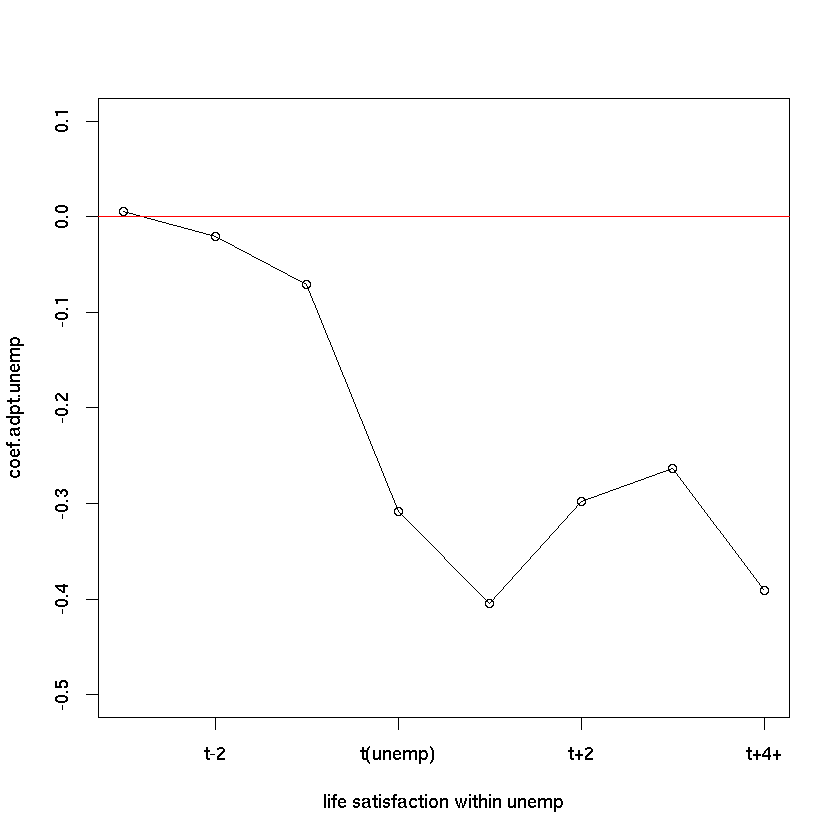

In [19]:
summary(adpt.unemp)

coef.adpt.unemp <- adpt.unemp$coefficients[1:8]#summary(adpt.unemp.m)

par(mfrow=c(1,3))
plot(coef.adpt.unemp,ylim=c(-0.5,0.1),type='o',xaxt = 'n',xlab='life satisfaction within unemp')
abline(h=0,col='red')
axis(1,at=c(2,4,6,8),labels=c('t-2','t(unemp)','t+2','t+4+')) 

# Modelling life satisfaction after unemp - the scarring effect (for those who found a job AND those who left paid employment)

## Data looks like:

In [105]:
vew <- data[,c('id','wave.num','emp','unemp','lfsato','postunemp.t1','postunemp.t2',
               'postunemp.t3','postunemp.t4','postunemp.t5')]
vew[2273:2285,]

,id,wave.num,emp,unemp,lfsato,postunemp.t1,postunemp.t2,postunemp.t3,postunemp.t4,postunemp.t5
2666,10246401,6,1,0,5,0,1,0,0,0
2667,10246401,7,1,0,5,0,0,1,0,0
2668,10246401,8,0,1,6,0,0,0,0,0
2669,10246401,9,0,1,5,0,0,0,0,0
2670,10246401,10,0,1,4,0,0,0,0,0
2671,10246401,11,0,0,NA,1,0,0,0,0
2672,10246401,12,1,0,5,0,1,0,0,0
2673,10246401,13,1,0,6,0,0,1,0,0
2674,10246401,14,1,0,5,0,0,0,1,0
2675,10246401,16,1,0,6,0,0,0,0,0


## Previous research - random effect

### The following model replicates Lucas et al.'s (2004) study which used a mixed model
- The important finding is that the coefficients of the postunemp dummies are all negative and significant

### Descriptive statistics

In [20]:
des <- data[,c('postunemp.t1','postunemp.t2','postunemp.t3','postunemp.t4','postunemp.t5')]
s <- sapply(des,sum)
d.s <- c(21868,'1-12',120739)
names(d.s) <- c('n (respondents)','T (waves)','N (observations)')
s
d.s

postunemp.t1 postunemp.t2 postunemp.t3 postunemp.t4 postunemp.t5 
        4410         3150         2474         1987         1619

n (respondents)        T (waves) N (observations) 
         "21868"           "1-12"         "120739"

### Model outputs

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lfsato ~ unemp.t_2 + unemp.t_1 + unemp.in.t1 + 
    unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus + 
    postunemp.t1 + postunemp.t2 + postunemp.t3 + postunemp.t4 + 
    postunemp.t5 + sex + age + hhincome, data = data, subset = (age <= 
    60), model = "random", index = c("id", "wave.num"))

Unbalanced Panel: n=21868, T=1-12, N=120739

Effects:
                 var std.dev share
idiosyncratic 0.7762  0.8810 0.511
individual    0.7431  0.8620 0.489
theta  : 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2852  0.5843  0.6775  0.6336  0.7170  0.7170 

Residuals :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.9400 -0.4590  0.1100  0.0008  0.5740  3.8400 

Coefficients :
                   Estimate  Std. Error  t-value  Pr(>|t|)    
(Intercept)      5.2845e+00  2.7207e-02 194.2308 < 2.2e-16 ***
unemp.t_2       -8.4460e-02  2.4706e-02  -3.4186 0.0006297 ***
unemp.t

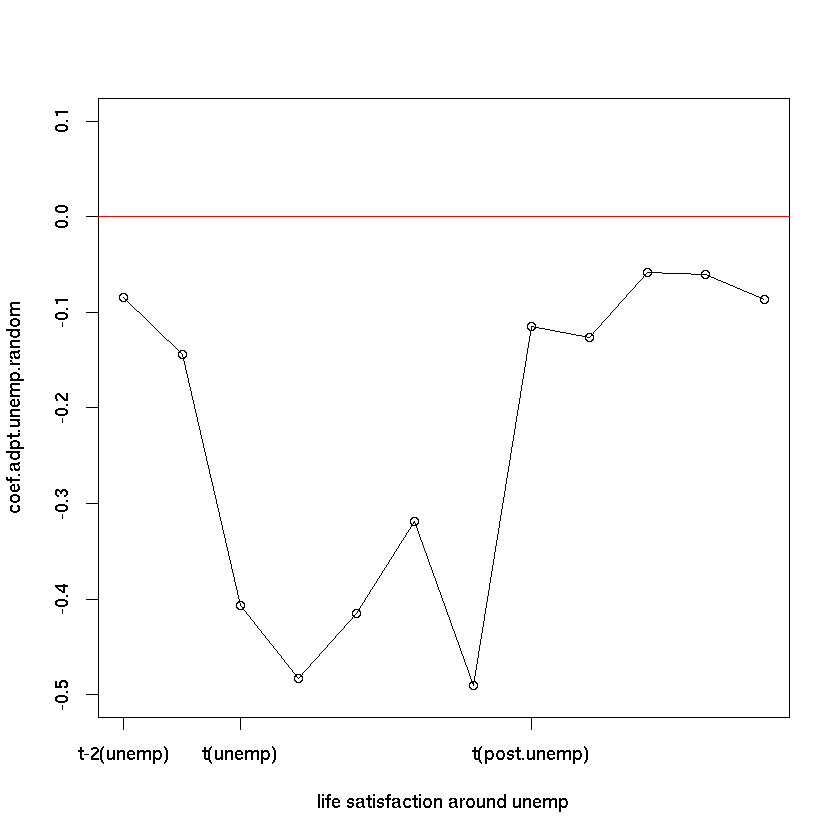

In [21]:
adpt.unemp.int.random <- plm(lfsato ~ unemp.t_2 + unemp.t_1 + 
			unemp.in.t1 + unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus +
			postunemp.t1 + postunemp.t2 + postunemp.t3  + 
			postunemp.t4  + postunemp.t5  + 
			sex + age + hhincome,
			data, subset = (age<=60),
			index = c('id','wave.num'), model = 'random')

summary(adpt.unemp.int.random)

coef.adpt.unemp.random <- adpt.unemp.int.random$coefficients[2:13]

plot(coef.adpt.unemp.random,ylim=c(-0.5,0.1),type='o',xaxt = 'n',xlab='life satisfaction around unemp')
abline(h=0,col='red')
axis(1,at=c(1,3,8),labels=c('t-2(unemp)','t(unemp)','t(post.unemp)')) 


## Previous research - fixed effect
 - Clark et al. (2001) modelled unemployment scarring effect on life satisfaction.
  - They found unemployment in last three years has a scarring effect on current life satisfaction, ***employed or unemployed***.
  - Most of the evidence was derived from comparing across respondents (ie, random effect).
  - They did conduct the fixed effect model to control for unobserved heterogeneity (for obvious reasons!).
    - They collapsed life satisfaction 0-10 into 0 and 1 (using 7 as the threshold), due to the fact (believe or not) we still don't have an ordered probit/logit fixed effect model!
    - They found evidence of the scarring effect from the male sample but not the female sample.
    

## If we run Lucas et al.'s model using fixed effect, we find a much less severe scarring effect
- The first year after unemployment is barely significant at 10% level.
- But note similar to Clark et al.'s (2001) paper (they are the same group of people!), the post unemployment dummies capture two distinctive groups of respondents:
  - Those who managed to find a job
  - Those who left paid employment 

### Model outputs

### We first run a Hausman test and indeed the results indicate the residuals are correlated with regressors


	Hausman Test

data:  lfsato ~ unemp.t_2 + unemp.t_1 + unemp.in.t1 + unemp.in.t2 +  ...
chisq = 589.18, df = 14, p-value < 2.2e-16
alternative hypothesis: one model is inconsistent


Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.t_2 + unemp.t_1 + unemp.in.t1 + 
    unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus + 
    postunemp.t1 + postunemp.t2 + postunemp.t3 + postunemp.t4 + 
    postunemp.t5 + age + hhincome, data = data, subset = (age <= 
    60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=21868, T=1-12, N=120740

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.31000 -0.40500  0.00663  0.46400  4.98000 

Coefficients :
                   Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.t_2       -3.4714e-02  2.5410e-02  -1.3661   0.17190    
unemp.t_1       -8.6104e-02  2.1640e-02  -3.9789 6.929e-05 ***
unemp.in.t1     -3.2797e-01  2.2225e-02 -14.7567 < 2.2e-16 ***
unemp.in.t2     -3.9284e-01  4.2481e-02  -9.2473 < 2.2e-16 ***
unemp.in.t3     -3.1347e-01  6.5826e-02  -4.7621 1.919e-06 ***
unemp.in.t4     -2.3427e-01  9.8381e-02  -2.3812   0.01726 *  
unemp.in.t5plus -4.4700e-01  1.0

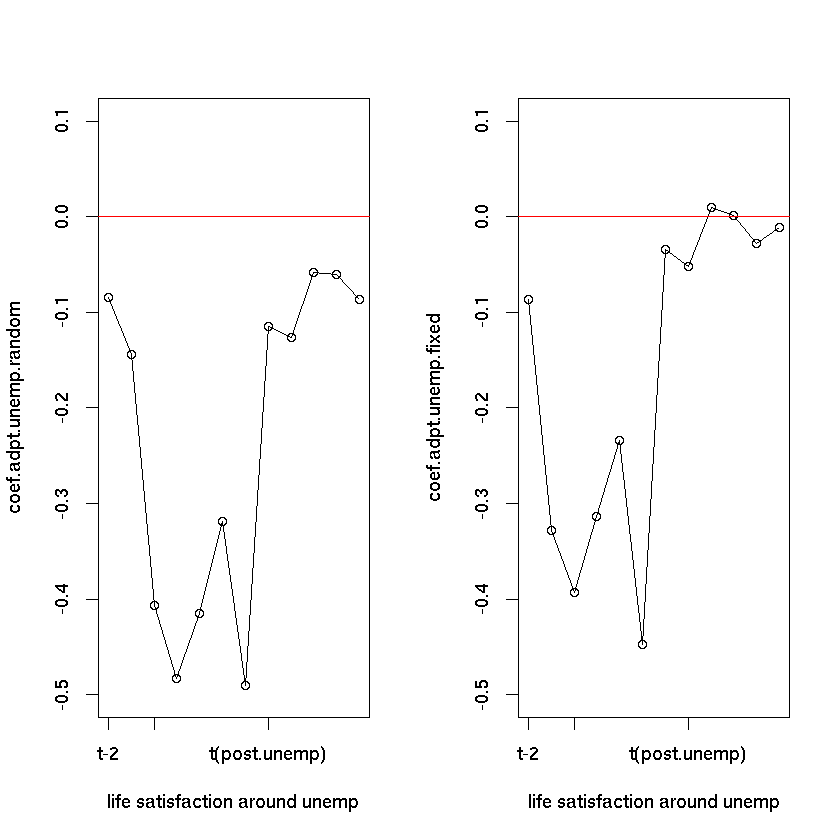

In [22]:
adpt.unemp.int.fixed <- plm(lfsato ~ unemp.t_2 + unemp.t_1 + 
			unemp.in.t1 + unemp.in.t2 + unemp.in.t3 + unemp.in.t4 + unemp.in.t5plus +
			postunemp.t1 + postunemp.t2 + postunemp.t3  + 
			postunemp.t4  + postunemp.t5  + 
			age + hhincome,
			data, subset = (age<=60),
			index = c('id','wave.num'), model = 'within')

#Run Hausman test
phtest(adpt.unemp.int.fixed, adpt.unemp.int.random)


summary(adpt.unemp.int.fixed)


coef.adpt.unemp.fixed <- adpt.unemp.int.fixed$coefficients[2:13]


par(mfrow=c(1,2))
plot(coef.adpt.unemp.random,ylim=c(-0.5,0.1),type='o',xaxt = 'n',xlab='life satisfaction around unemp')
abline(h=0,col='red')
axis(1,at=c(1,3,8),labels=c('t-2','t(unemp)','t(post.unemp)')) 
plot(coef.adpt.unemp.fixed,ylim=c(-0.5,0.1),type='o',xaxt = 'n',xlab='life satisfaction around unemp')
abline(h=0,col='red')
axis(1,at=c(1,3,8),labels=c('t-2','t(unemp)','t(post.unemp)')) 

# Modelling life satisfaction after unemp (our approach - fixed effect)

### We split the respondents into two groups (those who found a job and those who left the paid employment) and see how unemployment influences their life satisfaction.
### For those who managed to find a job after unemployment, the data looks like:

In [109]:
vew <- data[,c('id','wave.num','emp','unemp','lfsato','unemp.lastyr.each.slot',
               'emp.postunemp.in1yr.t1','emp.postunemp.in1yr.t2','emp.postunemp.in1yr.t3',
               'emp.postunemp.in1yr.t4','emp.postunemp.in1yr.t5')]
vew[2605:2615,]

,id,wave.num,emp,unemp,lfsato,unemp.lastyr.each.slot,emp.postunemp.in1yr.t1,emp.postunemp.in1yr.t2,emp.postunemp.in1yr.t3,emp.postunemp.in1yr.t4,emp.postunemp.in1yr.t5
3035,10306838,8,1,0,3,0,0,0,0,0,0
3036,10306897,1,0,1,NA,0,0,0,0,0,0
3037,10306897,2,0,1,NA,1,0,0,0,0,0
3038,10306897,3,1,0,NA,0,1,0,0,0,0
3039,10306897,4,1,0,NA,0,0,1,0,0,0
3040,10306897,5,1,0,NA,0,0,0,1,0,0
3041,10306897,6,1,0,6,0,0,0,0,1,0
3042,10306897,7,1,0,5,0,0,0,0,0,1
3043,10306897,8,1,0,5,0,0,0,0,0,0
3044,10306897,9,1,0,5,0,0,0,0,0,0


### For those who left paid employment after unemployment, the data looks like:

In [110]:
vew <- data[,c('id','wave.num','emp','unemp','lfsato','unemp.lastyr.each.slot',
               'nonemp.postunemp.in1yr.t1','nonemp.postunemp.in1yr.t2','nonemp.postunemp.in1yr.t3',
               'nonemp.postunemp.in1yr.t4','nonemp.postunemp.in1yr.t5')]
vew[1575:1585,]

,id,wave.num,emp,unemp,lfsato,unemp.lastyr.each.slot,nonemp.postunemp.in1yr.t1,nonemp.postunemp.in1yr.t2,nonemp.postunemp.in1yr.t3,nonemp.postunemp.in1yr.t4,nonemp.postunemp.in1yr.t5
1826,10162771,12,1,0,NA,0,0,0,0,0,0
1827,10162771,14,0,0,NA,0,0,0,0,0,0
1828,10163492,1,0,1,NA,0,0,0,0,0,0
1829,10163492,2,0,1,NA,1,0,0,0,0,0
1830,10163492,3,0,0,NA,0,1,0,0,0,0
1831,10163492,4,0,0,NA,0,0,1,0,0,0
1832,10163492,5,0,0,NA,0,0,0,1,0,0
1833,10163492,6,1,0,3,0,0,0,0,0,0
1834,10163492,7,0,0,2,0,0,0,0,0,0
1835,10163492,8,0,0,3,0,0,0,0,0,0


## Life satisfation after unemployment (fixed effect) - found a job

### Descriptive statistics

In [23]:
des <- data[,c('emp.postunemp.in1yr.t1','emp.postunemp.in1yr.t2','emp.postunemp.in1yr.t3','emp.postunemp.in1yr.t4','emp.postunemp.in1yr.t5')]
s <- sapply(des,sum)
names(s)[1] <- 'last year in unemp'
d.s <- c(20967,'1-11',108227)
names(d.s) <- c('n (respondents)','T (waves)','N (observations)')
print('Overall')
s
d.s
summary(des)
dim(des)
summary(data$sex)

des <- data[data$sex==1,c('emp.postunemp.in1yr.t1','emp.postunemp.in1yr.t2','emp.postunemp.in1yr.t3','emp.postunemp.in1yr.t4','emp.postunemp.in1yr.t5')]
s <- sapply(des,sum,na.rm=T)
names(s)[1] <- 'last year in unemp'
d.s <- c(9915,'1-11',49742)
names(d.s) <- c('n (respondents)','T (waves)','N (observations)')
print('Male')
s
d.s
summary(des)
dim(des)

des <- data[data$sex==2,c('emp.postunemp.in1yr.t1','emp.postunemp.in1yr.t2','emp.postunemp.in1yr.t3','emp.postunemp.in1yr.t4','emp.postunemp.in1yr.t5')]
s <- sapply(des,sum,na.rm=T)
names(s)[1] <- 'last year in unemp'
d.s <- c(11052,'1-11',58485)
names(d.s) <- c('n (respondents)','T (waves)','N (observations)')
print('Female')
s
d.s
summary(des)
dim(des)

[1] "Overall"


last year in unemp emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3 
                  2270                   1522                   1133 
emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5 
                   860                    678

n (respondents)        T (waves) N (observations) 
         "20967"           "1-11"         "108227"

 emp.postunemp.in1yr.t1 emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3
 Min.   :0.00000        Min.   :0.000000       Min.   :0.000000      
 1st Qu.:0.00000        1st Qu.:0.000000       1st Qu.:0.000000      
 Median :0.00000        Median :0.000000       Median :0.000000      
 Mean   :0.01153        Mean   :0.007733       Mean   :0.005756      
 3rd Qu.:0.00000        3rd Qu.:0.000000       3rd Qu.:0.000000      
 Max.   :1.00000        Max.   :1.000000       Max.   :1.000000      
 emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5
 Min.   :0.000000       Min.   :0.000000      
 1st Qu.:0.000000       1st Qu.:0.000000      
 Median :0.000000       Median :0.000000      
 Mean   :0.004369       Mean   :0.003445      
 3rd Qu.:0.000000       3rd Qu.:0.000000      
 Max.   :1.000000       Max.   :1.000000      

[1] 196828      5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   2.000   1.531   2.000   2.000    1779 

[1] "Male"


last year in unemp emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3 
                  1358                    892                    673 
emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5 
                   525                    421

n (respondents)        T (waves) N (observations) 
          "9915"           "1-11"          "49742"

 emp.postunemp.in1yr.t1 emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3
 Min.   :0.0000         Min.   :0.0000         Min.   :0.0000        
 1st Qu.:0.0000         1st Qu.:0.0000         1st Qu.:0.0000        
 Median :0.0000         Median :0.0000         Median :0.0000        
 Mean   :0.0148         Mean   :0.0097         Mean   :0.0074        
 3rd Qu.:0.0000         3rd Qu.:0.0000         3rd Qu.:0.0000        
 Max.   :1.0000         Max.   :1.0000         Max.   :1.0000        
 NA's   :1779           NA's   :1779           NA's   :1779          
 emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5
 Min.   :0.0000         Min.   :0.0000        
 1st Qu.:0.0000         1st Qu.:0.0000        
 Median :0.0000         Median :0.0000        
 Mean   :0.0057         Mean   :0.0046        
 3rd Qu.:0.0000         3rd Qu.:0.0000        
 Max.   :1.0000         Max.   :1.0000        
 NA's   :1779           NA's   :1779          

[1] 93321     5

[1] "Female"


last year in unemp emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3 
                   898                    622                    451 
emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5 
                   332                    252

n (respondents)        T (waves) N (observations) 
         "11052"           "1-11"          "58485"

 emp.postunemp.in1yr.t1 emp.postunemp.in1yr.t2 emp.postunemp.in1yr.t3
 Min.   :0.0000         Min.   :0.000          Min.   :0.0000        
 1st Qu.:0.0000         1st Qu.:0.000          1st Qu.:0.0000        
 Median :0.0000         Median :0.000          Median :0.0000        
 Mean   :0.0087         Mean   :0.006          Mean   :0.0044        
 3rd Qu.:0.0000         3rd Qu.:0.000          3rd Qu.:0.0000        
 Max.   :1.0000         Max.   :1.000          Max.   :1.0000        
 NA's   :1779           NA's   :1779           NA's   :1779          
 emp.postunemp.in1yr.t4 emp.postunemp.in1yr.t5
 Min.   :0.0000         Min.   :0.0000        
 1st Qu.:0.0000         1st Qu.:0.0000        
 Median :0.0000         Median :0.0000        
 Mean   :0.0032         Mean   :0.0024        
 3rd Qu.:0.0000         3rd Qu.:0.0000        
 Max.   :1.0000         Max.   :1.0000        
 NA's   :1779           NA's   :1779          

[1] 105286      5

### Model outputs
- Instead of scarring effects, we've found **boosting** effects!
 - In the year they found the job, there is a surge in life satisfaction (which is expected)!
 - In the following year, life satisfaction drops back. 
 - This is similar to the honey moon-hangover effect in job switiching. 
 - After that, life is all good again (oh yeah)!
- The boosting effects only exist in the male sample, though.

In [24]:
## Life satisfation after unemployment (fixed effect) - found a job
## adpt post unemp - employed - within ##

## employed within t1 ##
# overall #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (age <=60),
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp <- adpt.unemp.int$coefficients[1:6]

# by sex #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==1 & age <=60), # sex=male
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp.m <- adpt.unemp.int$coefficients[1:6]


adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==2 & age <=60), # sex=female
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp.f <- adpt.unemp.int$coefficients[1:6]

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (age <= 
    60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=20967, T=1-11, N=108227

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.39200  0.00627  0.44600  4.57000 

Coefficients :
                          Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot -2.1907e-01  2.1010e-02 -10.4271 < 2.2e-16 ***
emp.postunemp.in1yr.t1  1.0066e-01  2.7611e-02   3.6458 0.0002668 ***
emp.postunemp.in1yr.t2  2.1025e-02  3.1597e-02   0.6654 0.5057851    
emp.postunemp.in1yr.t3  8.7297e-02  3.4967e-02   2.4966 0.0125415 *  
emp.postunemp.in1yr.t4  8.1617e-02  3.8416e-02   2.1246 0.0336254 *  
emp.postunemp.in

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    1 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=9915, T=1-11, N=49742

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.12000 -0.37700  0.00475  0.42800  4.53000 

Coefficients :
                          Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot -2.1111e-01  2.8860e-02  -7.3150 2.622e-13 ***
emp.postunemp.in1yr.t1  1.4227e-01  3.5554e-02   4.0016 6.303e-05 ***
emp.postunemp.in1yr.t2  1.3024e-02  4.0598e-02   0.3208   0.74837    
emp.postunemp.in1yr.t3  8.2539e-02  4.4783e-02   1.8431   0.06532 .  
emp.postunemp.in1yr.t4  8.1873e-02  4.7662e-02   1.7178   0.08584 .  
emp.pos

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    2 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=11052, T=1-11, N=58485

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.40700  0.00685  0.46100  4.59000 

Coefficients :
                          Estimate  Std. Error t-value  Pr(>|t|)    
unemp.lastyr.each.slot -2.2393e-01  3.0387e-02 -7.3694 1.741e-13 ***
emp.postunemp.in1yr.t1  4.8638e-02  4.2997e-02  1.1312   0.25798    
emp.postunemp.in1yr.t2  3.4956e-02  4.9318e-02  0.7088   0.47846    
emp.postunemp.in1yr.t3  9.8471e-02  5.4754e-02  1.7984   0.07212 .  
emp.postunemp.in1yr.t4  8.5801e-02  6.2953e-02  1.3629   0.17291    
emp.postunem

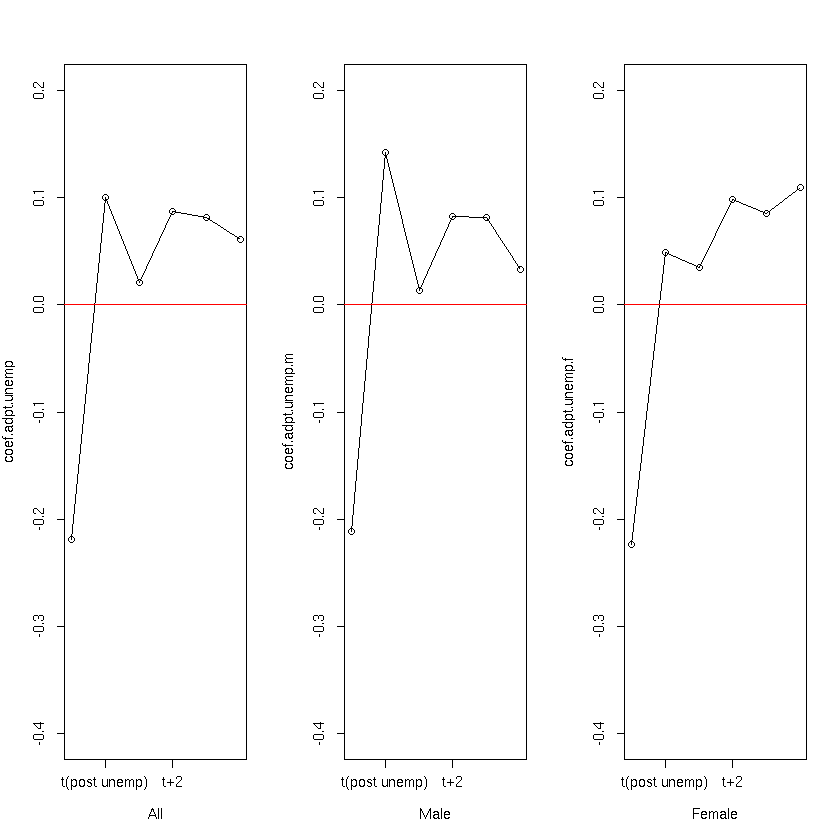

In [25]:
# plot #
par(mfrow=c(1,3))

plot(coef.adpt.unemp,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='All')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

plot(coef.adpt.unemp.m,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='Male')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

plot(coef.adpt.unemp.f,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='Female')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

### Robustness check - found a job within t1-3 - similar patterns

In [26]:
## employed within t1-2 ##
# overall #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
			emp.postunemp.in1_2yr.t1 + emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + 
            emp.postunemp.in1_2yr.t4 + emp.postunemp.in1_2yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (age <=60),
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)

# by sex #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1_2yr.t1 + emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + 
            emp.postunemp.in1_2yr.t4 + emp.postunemp.in1_2yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==1 & age <=60), # sex=male
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1_2yr.t1 + emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + 
            emp.postunemp.in1_2yr.t4 + emp.postunemp.in1_2yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==2 & age <=60), # sex=female
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)


## employed within t1-3 ##
# overall #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
			emp.postunemp.in1_3yr.t1 + emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + 
            emp.postunemp.in1_3yr.t4 + emp.postunemp.in1_3yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (age <=60),
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)

# by sex #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1_3yr.t1 + emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + 
            emp.postunemp.in1_3yr.t4 + emp.postunemp.in1_3yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==1 & age <=60), # sex=male
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1_3yr.t1 + emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + 
            emp.postunemp.in1_3yr.t4 + emp.postunemp.in1_3yr.t5 + 
			age + I(age^2) + as.factor(academic) +
			hhincome + couple + nchild + health ,
			data, subset = (sex==2 & age <=60), # sex=female
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_2yr.t1 + 
    emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + emp.postunemp.in1_2yr.t4 + 
    emp.postunemp.in1_2yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (age <= 
    60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=20967, T=1-11, N=108227

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.39200  0.00623  0.44600  4.58000 

Coefficients :
                            Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.1449e-01  2.1044e-02 -10.1922 < 2.2e-16 ***
emp.postunemp.in1_2yr.t1  1.1604e-01  2.6187e-02   4.4311 9.385e-06 ***
emp.postunemp.in1_2yr.t2  3.9878e-02  3.0021e-02   1.3283   0.18407    
emp.postunemp.in1_2yr.t3  8.2389e-02  3.3220e-02   2.4801   0.01314 *  
emp.postunemp.in1_2yr.t4  7.9938e-02  3.6274e-02   2.2038   0.0275

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_2yr.t1 + 
    emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + emp.postunemp.in1_2yr.t4 + 
    emp.postunemp.in1_2yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    1 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=9915, T=1-11, N=49742

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.12000 -0.37700  0.00483  0.42800  4.53000 

Coefficients :
                            Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.0428e-01  2.8897e-02  -7.0694 1.582e-12 ***
emp.postunemp.in1_2yr.t1  1.6009e-01  3.4125e-02   4.6914 2.722e-06 ***
emp.postunemp.in1_2yr.t2  4.0047e-02  3.9233e-02   1.0208   0.30737    
emp.postunemp.in1_2yr.t3  8.7128e-02  4.3334e-02   2.0106   0.04438 *  
emp.postunemp.in1_2yr.t4  7.5657e-02  4.5919e-02   1.6476

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_2yr.t1 + 
    emp.postunemp.in1_2yr.t2 + emp.postunemp.in1_2yr.t3 + emp.postunemp.in1_2yr.t4 + 
    emp.postunemp.in1_2yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    2 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=11052, T=1-11, N=58485

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.40700  0.00699  0.46200  4.59000 

Coefficients :
                            Estimate  Std. Error t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.2146e-01  3.0448e-02 -7.2736 3.555e-13 ***
emp.postunemp.in1_2yr.t1  6.4020e-02  4.0169e-02  1.5938   0.11099    
emp.postunemp.in1_2yr.t2  4.2082e-02  4.5856e-02  0.9177   0.35877    
emp.postunemp.in1_2yr.t3  8.0517e-02  5.0819e-02  1.5844   0.11311    
emp.postunemp.in1_2yr.t4  8.9738e-02  5.7703e-02  1.5552   0.

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_3yr.t1 + 
    emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + emp.postunemp.in1_3yr.t4 + 
    emp.postunemp.in1_3yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (age <= 
    60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=20967, T=1-11, N=108227

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.39200  0.00629  0.44600  4.57000 

Coefficients :
                            Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.1454e-01  2.1043e-02 -10.1956 < 2.2e-16 ***
emp.postunemp.in1_3yr.t1  1.0997e-01  2.4782e-02   4.4376 9.109e-06 ***
emp.postunemp.in1_3yr.t2  4.1086e-02  2.8672e-02   1.4330   0.15186    
emp.postunemp.in1_3yr.t3  7.6539e-02  3.1613e-02   2.4211   0.01548 *  
emp.postunemp.in1_3yr.t4  7.0421e-02  3.4556e-02   2.0379   0.0415

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_3yr.t1 + 
    emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + emp.postunemp.in1_3yr.t4 + 
    emp.postunemp.in1_3yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    1 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=9915, T=1-11, N=49742

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.12000 -0.37700  0.00489  0.42900  4.53000 

Coefficients :
                            Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.0658e-01  2.8874e-02  -7.1546 8.536e-13 ***
emp.postunemp.in1_3yr.t1  1.4412e-01  3.2430e-02   4.4441 8.849e-06 ***
emp.postunemp.in1_3yr.t2  3.5737e-02  3.7622e-02   0.9499   0.34216    
emp.postunemp.in1_3yr.t3  7.7281e-02  4.1500e-02   1.8622   0.06259 .  
emp.postunemp.in1_3yr.t4  6.5698e-02  4.3878e-02   1.4973

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1_3yr.t1 + 
    emp.postunemp.in1_3yr.t2 + emp.postunemp.in1_3yr.t3 + emp.postunemp.in1_3yr.t4 + 
    emp.postunemp.in1_3yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    2 & age <= 60), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=11052, T=1-11, N=58485

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.40700  0.00708  0.46200  4.58000 

Coefficients :
                            Estimate  Std. Error t-value  Pr(>|t|)    
unemp.lastyr.each.slot   -2.1956e-01  3.0467e-02 -7.2066 5.820e-13 ***
emp.postunemp.in1_3yr.t1  7.0628e-02  3.7812e-02  1.8679   0.06179 .  
emp.postunemp.in1_3yr.t2  4.9137e-02  4.3580e-02  1.1275   0.25953    
emp.postunemp.in1_3yr.t3  7.8746e-02  4.7997e-02  1.6406   0.10088    
emp.postunemp.in1_3yr.t4  7.9880e-02  5.4750e-02  1.4590   0.

In [27]:
## adpt post unemp - employed - random ##

# overall #
adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + sex +
			hhincome + couple + nchild + health ,
			data, 
			index = c('id','wave.num'), model = 'random')
summary(adpt.unemp.int)

# by sex #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + sex +
			hhincome + couple + nchild + health ,
			data, subset = (sex==1), # sex=male
			index = c('id','wave.num'), model = 'random')
summary(adpt.unemp.int)

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			emp.postunemp.in1yr.t1 + emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + emp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + sex +
			hhincome + couple + nchild + health ,
			data, subset = (sex==2), # sex=female
			index = c('id','wave.num'), model = 'random')
summary(adpt.unemp.int)


Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    sex + hhincome + couple + nchild + health, data = data, model = "random", 
    index = c("id", "wave.num"))

Unbalanced Panel: n=22103, T=1-11, N=116757

Effects:
                 var std.dev share
idiosyncratic 0.7472  0.8644 0.581
individual    0.5382  0.7336 0.419
theta  : 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2376  0.5338  0.6154  0.5800  0.6652  0.6652 

Residuals :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.0100 -0.4610  0.0981  0.0013  0.5710  4.0800 

Coefficients :
                          Estimate  Std. Error  t-value  Pr(>|t|)    
(Intercept)             4.8343e+00  5.7145e-02  84.5979 < 2.2e-16 ***
unemp.lastyr.each.slot -2.6962e-01  2.005

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    sex + hhincome + couple + nchild + health, data = data, subset = (sex == 
    1), model = "random", index = c("id", "wave.num"))

Unbalanced Panel: n=10439, T=1-11, N=53622

Effects:
                 var std.dev share
idiosyncratic 0.6921  0.8319 0.578
individual    0.5056  0.7111 0.422
theta  : 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2398  0.5364  0.6178  0.5788  0.6673  0.6673 

Residuals :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.9000 -0.4390  0.0952  0.0035  0.5500  3.8500 

Coefficients :
                          Estimate  Std. Error  t-value Pr(>|t|)    
(Intercept)             5.0226e+00  7.5998e-02  66.0884  < 2e-16 ***
unemp.lastyr.each.slot 

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + emp.postunemp.in1yr.t1 + 
    emp.postunemp.in1yr.t2 + emp.postunemp.in1yr.t3 + emp.postunemp.in1yr.t4 + 
    emp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    sex + hhincome + couple + nchild + health, data = data, subset = (sex == 
    2), model = "random", index = c("id", "wave.num"))

Unbalanced Panel: n=11664, T=1-11, N=63135

Effects:
                 var std.dev share
idiosyncratic 0.7928  0.8904 0.584
individual    0.5647  0.7514 0.416
theta  : 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2358  0.5645  0.6136  0.5811  0.6636  0.6636 

Residuals :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.0200 -0.4790  0.1010 -0.0004  0.5890  4.0600 

Coefficients :
                          Estimate  Std. Error  t-value  Pr(>|t|)    
(Intercept)             4.8092e+00  7.7407e-02  62.1287 < 2.2e-16 ***
unemp.lastyr.each.slo

## Life satisfation after unemployment (fixed effect) - left paid employment

### Model outputs
- There are scarring effects in the first two years.
- Disappears over time.
- Only exists for males.
- Might need to remove the last dummy which is confusing.

In [29]:
## adpt post unemp - non-employed - fixed ##

# overall #


adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
			nonemp.postunemp.in1yr.t1 + nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + nonemp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + 
			hhincome + couple + nchild + health ,
			data, 
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp <- adpt.unemp.int$coefficients[1:6]


# by sex #

adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			nonemp.postunemp.in1yr.t1 + nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + nonemp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + 
			hhincome + couple + nchild + health ,
			data, subset = (sex==1), # sex=male
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp.m <- adpt.unemp.int$coefficients[1:6]


adpt.unemp.int <- plm(lfsato ~ unemp.lastyr.each.slot + 
 			nonemp.postunemp.in1yr.t1 + nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + nonemp.postunemp.in1yr.t5 + 
			age + I(age^2) + as.factor(academic) + 
			hhincome + couple + nchild + health ,
			data, subset = (sex==2), # sex=female
			index = c('id','wave.num'), model = 'within')
summary(adpt.unemp.int)
coef.adpt.unemp.f <- adpt.unemp.int$coefficients[1:6]


Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + nonemp.postunemp.in1yr.t1 + 
    nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + 
    nonemp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, model = "within", 
    index = c("id", "wave.num"))

Unbalanced Panel: n=22103, T=1-11, N=116757

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.39100  0.00813  0.44400  4.55000 

Coefficients :
                             Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot    -2.5333e-01  2.0617e-02 -12.2876 < 2.2e-16 ***
nonemp.postunemp.in1yr.t1 -7.5055e-02  2.8300e-02  -2.6521  0.008000 ** 
nonemp.postunemp.in1yr.t2 -7.1537e-02  3.5680e-02  -2.0050  0.044970 *  
nonemp.postunemp.in1yr.t3 -4.2749e-02  4.0687e-02  -1.0507  0.293400    
nonemp.postunemp.in1yr.t4 -4.1318e-03  4.5146e-02  -0.0915  0.927079    
nonem

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + nonemp.postunemp.in1yr.t1 + 
    nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + 
    nonemp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    1), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=10439, T=1-11, N=53622

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.12000 -0.37400  0.00708  0.42400  4.53000 

Coefficients :
                             Estimate  Std. Error  t-value  Pr(>|t|)    
unemp.lastyr.each.slot    -2.5280e-01  2.7735e-02  -9.1148 < 2.2e-16 ***
nonemp.postunemp.in1yr.t1 -1.0637e-01  4.0092e-02  -2.6531 0.0079774 ** 
nonemp.postunemp.in1yr.t2 -7.6531e-02  5.2681e-02  -1.4527 0.1463093    
nonemp.postunemp.in1yr.t3 -2.3435e-01  6.1006e-02  -3.8413 0.0001225 ***
nonemp.postunemp.in1yr.t4 -2.3104e-04  6.7691e-02  -0.0034

Oneway (individual) effect Within Model

Call:
plm(formula = lfsato ~ unemp.lastyr.each.slot + nonemp.postunemp.in1yr.t1 + 
    nonemp.postunemp.in1yr.t2 + nonemp.postunemp.in1yr.t3 + nonemp.postunemp.in1yr.t4 + 
    nonemp.postunemp.in1yr.t5 + age + I(age^2) + as.factor(academic) + 
    hhincome + couple + nchild + health, data = data, subset = (sex == 
    2), model = "within", index = c("id", "wave.num"))

Unbalanced Panel: n=11664, T=1-11, N=63135

Residuals :
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.40000 -0.40700  0.00925  0.46200  4.49000 

Coefficients :
                             Estimate  Std. Error t-value  Pr(>|t|)    
unemp.lastyr.each.slot    -2.5197e-01  3.0414e-02 -8.2846 < 2.2e-16 ***
nonemp.postunemp.in1yr.t1 -4.6110e-02  3.9735e-02 -1.1605   0.24587    
nonemp.postunemp.in1yr.t2 -6.6076e-02  4.8486e-02 -1.3628   0.17296    
nonemp.postunemp.in1yr.t3  9.1276e-02  5.4689e-02  1.6690   0.09512 .  
nonemp.postunemp.in1yr.t4 -5.4224e-03  6.0687e-02 -0.0894   0.9

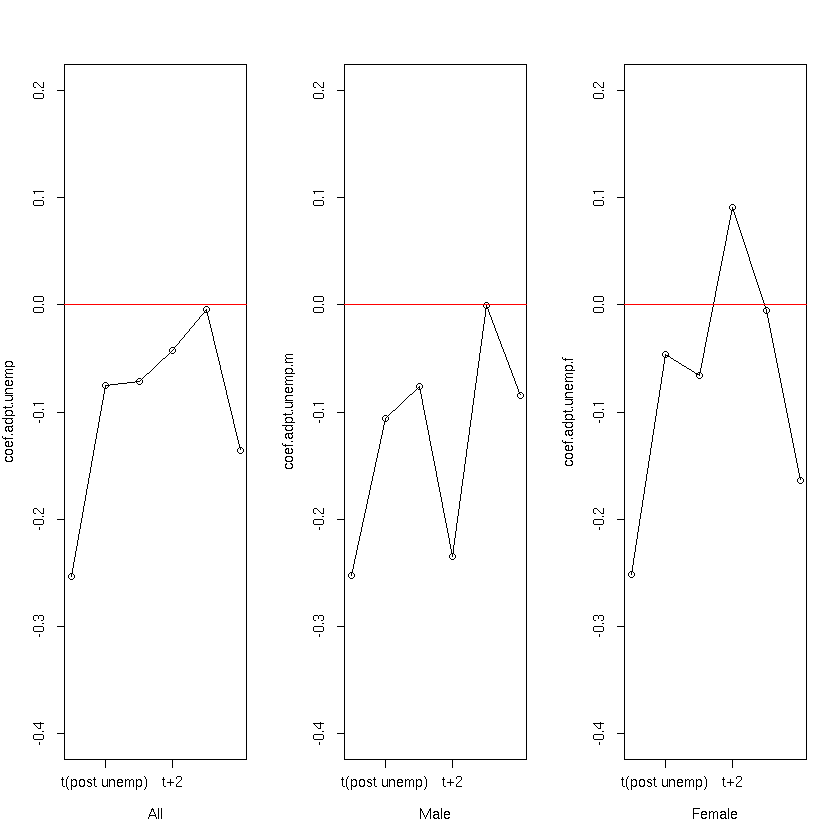

In [30]:
# plot #
par(mfrow=c(1,3))

plot(coef.adpt.unemp,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='All')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

plot(coef.adpt.unemp.m,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='Male')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

plot(coef.adpt.unemp.f,ylim=c(-0.4,0.2),type='o',xaxt = 'n',xlab='Female')
abline(h=0,col='red')
axis(1,at=c(2,4),labels=c('t(post unemp)','t+2')) 

### Random effect models - very clear scarring effects